Let's generate some data!

In [249]:
import datetime, numpy, random, pandas

def generate_time_series(k=700, m=1000, n=100, start_date=datetime.date(2017, 1, 1)):
    xs = numpy.linspace(0, 1, n, endpoint=False)
    ys = [k*x + m + random.gauss(0, 500) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    return pandas.DataFrame({'x': xs, 't': ts, 'y': ys})

def generate_logistic_data(k=2.5, m=0.3, n=100):
    from scipy.special import expit
    def bernoulli(z): return float(random.random() < z)
    xs = [random.gauss(0, 1) for _ in range(n)]
    ys = [bernoulli(expit(k*x + m)) for x in xs]
    return pandas.DataFrame({'x': xs, 'y': ys})

d = generate_time_series()

Let's plot to see what's going on!

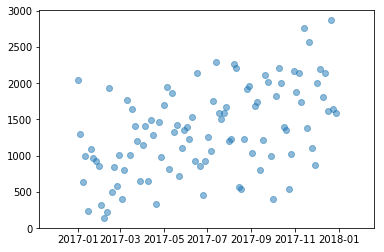

In [250]:
from matplotlib import pyplot
pyplot.scatter(list(d['t']), d['y'], alpha=0.5)  # not sure why i have to convert it to a list?
pyplot.show()

First of all, let's not fit any fancy models. We're just going to break it up into a few buckets and compute the mean within each bucket. But let's first pause and talk about uncertainty.

# Distribution of the data vs uncertainty

This makes me sometimes feel dumb but I keep confusing what "uncertainty" means and I think it's important to be hyper clear because we're going to do all of them. Let's say we're trying to understand quantity sold as a function of cost. There's multiple different things we can estimate the distribution for:

1. The data itself. Given a certain cost $x$, what's the distribution of outcomes in the data
2. The uncertainty of some parameter, like the parameter $k$ in a linear relationship $y = kx + m$.
3. The uncertainty of predicted quantities. So if we predict that for a cost $x$ then we're going to sell quantity $y$, we want to know the uncertainty of the quantity $y$.

Hope that makes sense! Let's start with the most basic model – just break things up in buckets.

In [251]:
d['month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))

I recommend the excellent Seaborn package if we just want to get some basic idea of distributions and uncertainty estimates:

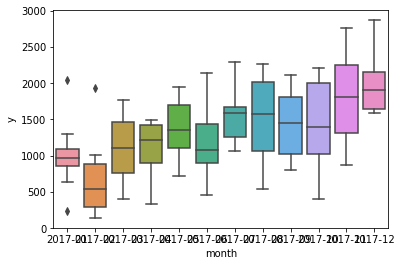

In [252]:
import seaborn
seaborn.boxplot(data=d, x='month', y='y')

Goofing around a bit with Seaborn is fun and you can use other plots like swarmplot:

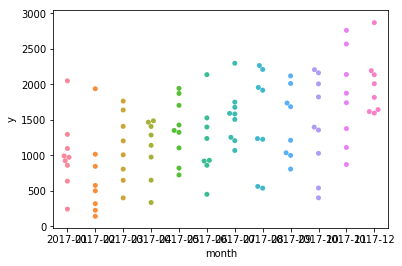

In [253]:
seaborn.swarmplot(data=d, x='month', y='y')

These last charts show the _distribution_ of the dataset.
If for whatever reason we want to compute the uncertainty of the average, turns out that Seaborn actually does that for barcharts:

/Users/erikbern/uncertainty/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


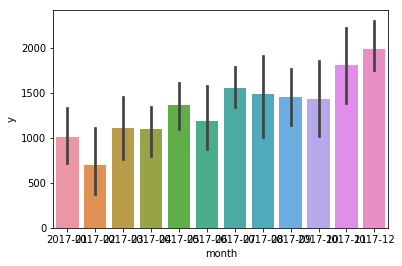

In [254]:
seaborn.barplot(data=d, x='month', y='y')

OK! enough fooling around with Seaborn. If we actually wanted to compute the uncertainty estimates ourselves, how would we do that?

Under some mild assumptions (I'm going to get back to this in a sec and scrutinize it), we can compute the confidence intervals as:

$\bar{x} \pm 1.96\sigma / \sqrt{n}$

Where $\bar{x}$ is the mean and $\sigma$ is the standard deviation, a.k.a. the square root of the variance. I don't think this formula is super important to remember, but I think it's somewhat useful to remember that the _size of the confidence interval is inversely related to the square root of the number of samples._ For instance, this is useful when you're running an A/B test – if you want to detect a 1% difference then you need something on the order of $0.01^{-2} = 10,000$ samples. (This is a rule of thumb, don't use it for your medical device software).

Let's compute this ourselves and split it (rather than relying on Seaborn):

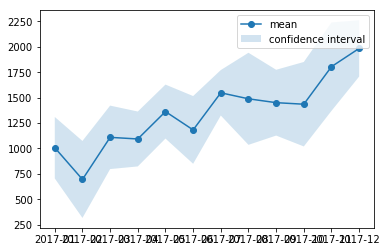

In [255]:
# This turns out to be somewhat annoying to do with Pandas,
# so we're just going to do it the old fashioned way:
observations_by_month = {}
for month, y in zip(d['month'], d['y']):
    observations_by_month.setdefault(month, []).append(y)
months = list(sorted(observations_by_month.keys()))
lo_bound = []
hi_bound = []
mean = []
for month in months:
    series = observations_by_month[month]
    mu, std, n = numpy.mean(series), numpy.std(series), len(series)
    mean.append(mu)
    lo_bound.append(mu - 1.96*std*n**-0.5)
    hi_bound.append(mu + 1.96*std*n**-0.5)
pyplot.clf()
pyplot.plot(months, mean, marker='o', label='mean')
pyplot.fill_between(months, lo_bound, hi_bound, alpha=0.2, label='confidence interval')
pyplot.legend()


I mentioned earlier that the formula for confidence interval only applies under some mild assumptions. What are those? It's the assumption of _normality_. For a large number of observations, this is nothing to worry about, and this is due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

There's one particular case of non-normality that I think is worth remembering. Consider the case when you're measuring something like a "conversion rate" – $k$ out of $n$ converted. Using the "off the shelf" formula for confidence intervals, you might get weird ones that go below 0% or above 100%. The confidence interval of a "$k$ out of $n$" scenario is much better handled using a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). I've personally benefitted from memorizing the formula for the confidence interval and think I probably use it more than the previous (Normal based) one. In particular all you need to remember is

In [256]:
scipy.stats.ppf([0.025, 0.975], n, n-k)

AttributeError: module 'scipy.stats' has no attribute 'ppf'

This will compute a 95% confidence interval if you plug in values for $n$ and $k$.

## Bootstrapping

Another approach that can be useful is bootstrapping. It allows you do compute the same statistics without memorizing any formulas.

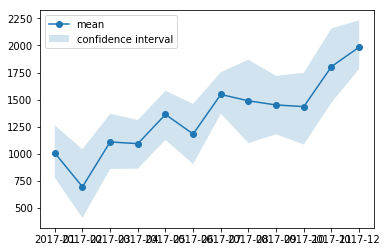

In [257]:
lo_bound = []
hi_bound = []
mean = []
for month in months:
    series = observations_by_month[month]
    bootstrapped_means = []
    for i in range(1000):
        bootstrap = [random.choice(series) for _ in series]  # sample with replacement
        bootstrapped_means.append(numpy.mean(bootstrap))
    mean.append(numpy.mean(series))
    lo_bound.append(numpy.percentile(bootstrapped_means, 5))
    hi_bound.append(numpy.percentile(bootstrapped_means, 95))
pyplot.clf()
pyplot.plot(months, mean, marker='o', label='mean')
pyplot.fill_between(months, lo_bound, hi_bound, alpha=0.2, label='confidence interval')
pyplot.legend()


Miraculously, these charts look basically identical! Just kidding – that was sort of expected :)

Bootstrapping is nice because it lets you dodge any questions about what probability distribution the data is generated from. However it also comes with some limitations that I quite honestly don't fully understand. I've used it successfully for cases where $n > 40$ or so, but below that, it seems to get a bit wonky.

# Regression

Let's crank it up a notch. We're going to fit a linear regression to this bad boy.

No handles with labels found to put in legend.


tup: [0. 0.]
tup: [1.49011612e-08 0.00000000e+00]
tup: [0.00000000e+00 1.49011612e-08]
tup: [0. 0.]
tup: [0.47071022 0.89360612]
tup: [0.47071022 0.89360612]
tup: [0.47071023 0.89360612]
tup: [0.47071022 0.89360613]
tup: [2.3535511  4.46803058]
tup: [2.3535511  4.46803058]
tup: [2.35355111 4.46803058]
tup: [2.3535511  4.46803059]
tup: [ 9.88491462 18.76572842]
tup: [ 9.88491462 18.76572842]
tup: [ 9.88491463 18.76572842]
tup: [ 9.88491462 18.76572843]
tup: [40.0103687  75.95651978]
tup: [40.0103687  75.95651978]
tup: [40.01036871 75.95651978]
tup: [40.0103687  75.95651979]
tup: [160.512185   304.71968523]
tup: [160.512185   304.71968523]
tup: [160.51218502 304.71968523]
tup: [160.512185   304.71968524]
tup: [ -55.45332427 1350.22350525]
tup: [ -55.45332427 1350.22350525]
tup: [ -55.45332426 1350.22350525]
tup: [ -55.45332427 1350.22350526]
tup: [ 7801.55209014 -2302.75906079]
tup: [ 7801.55209014 -2302.75906079]
tup: [ 7801.55209015 -2302.75906079]
tup: [ 7801.55209014 -2302.75906078]


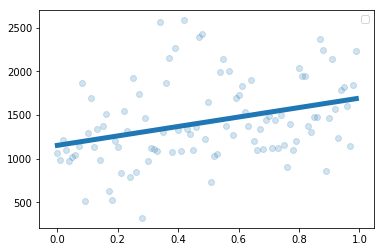

In [262]:
import scipy.optimize

d = generate_time_series()
xs = numpy.array(d['x'])
ys = numpy.array(d['y'])

def l2_loss(tup, xs, ys):
    k, m = tup
    delta = k * xs + m - ys
    return numpy.dot(delta, delta)

# Note: we could make the optimization much faster by either (a) using a gradient-based method (b) used the closed form solution.
# I'm fully aware of those tricks, but think they make the code slightly less general
k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs, ys)).x
pyplot.scatter(xs, ys, alpha=0.2)
pyplot.plot(xs, xs*k_hat + m_hat, linewidth=5)
pyplot.legend()

So let's take it to the next level and try to estimate the uncertainty estimate of $k$ and $m$! I like bootstrapping here because it's basically cookie cutter – we don't need to know any formula for it (side note: turns out there _is_ a formulate for it, but it's something complex with a [hyperbolic shape](https://en.wikipedia.org/wiki/Simple_linear_regression#Normality_assumption)... either way I think at this point it's almost useless to try to memorize).

So let's use bootstrap. For every bootstrap estimate, I'm going to draw a line:

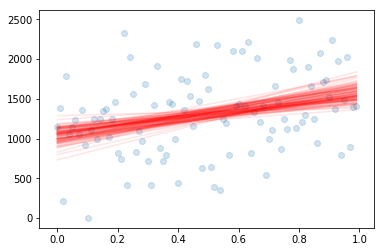

In [259]:
pyplot.scatter(xs, ys, alpha=0.2)
xys = list(zip(xs, ys))
for i in range(100):
    bootstrap = [random.choice(xys) for _ in xys]  # sample with replacement
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(l2_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)).x
    pyplot.plot(xs, xs*k_hat + m_hat, alpha=0.1, color='red')


Now we got any number of lines that we want, and we can use those lines to compute a confidence interval in a pretty straightforward way – for every point just pick the 5th and 95th percentile lines and that is the confidence interval! I'm not going to do that – will leave it as an exercise for the reader.

It should be added that one of the beauties of this method is that it extends to almost anything you're trying to fit. We can easily do the same thing for a logistic regression model:

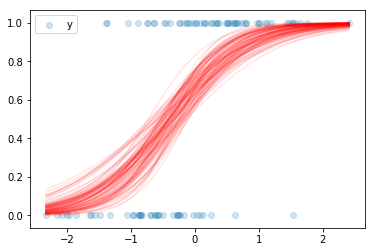

In [260]:
d = generate_logistic_data()
xs = d['x']
ys = d['y']

def logistic_loss(tup, xs, ys):
    k, m = tup
    y_hat = 1 / (1 + numpy.exp(-(k * xs + m)))
    return -numpy.dot(ys, numpy.log(y_hat)) + -numpy.dot(1-ys, numpy.log(1-y_hat))

pyplot.scatter(xs, ys, alpha=0.2)

xys = list(zip(xs, ys))
xs_hat = numpy.linspace(min(xs), max(xs), 200)
for i in range(100):
    bootstrap = [random.choice(xys) for _ in xys]  # sample with replacement
    xs_bootstrap = numpy.array([x for x, y in bootstrap])
    ys_bootstrap = numpy.array([y for x, y in bootstrap])
    k_hat, m_hat = scipy.optimize.minimize(logistic_loss, (0, 0), args=(xs_bootstrap, ys_bootstrap)).x
    pyplot.plot(xs_hat, 1/(1+numpy.exp(-(k_hat * xs_hat + m_hat))), alpha=0.1, color='red')
pyplot.legend()

# Bayesian methods

It's going to get a bit wilder now. I'm going to switch to some Bayesian methods, where we estimate $k$ and $m$ by drawing samples.  For this, we're going to use a library called [emcee](http://emcee.readthedocs.io/) which I've found pretty easy to use compared to all the ones I've tried so far. All it needs is a [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood) funcction. As it turns out we already have one – our earlier loss function! Having a log-likelihood (in our case $log P(x, y | k, m)$) gives us way to sample from the joint likelihood $P(k, m | x, y)$.

In [ ]:
import emcee
xs = d['x']
ys = d['y']
ndim, nwalkers = 2, 10
p0 = [numpy.random.rand(2) for i in range(nwalkers)]
log_likelihood = lambda tup, xs, ys: -l2_loss(tup, xs, ys)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[xs, ys])
sampler.run_mcmc(p0, 100)